<a href="https://colab.research.google.com/github/vippatil1604/air_quality_index_forecasting/blob/main/SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.mirror.amaze.com.au/spark/spark-3.0.2/spark-3.0.2-bin-hadoop3.2.tgz
!tar xf spark-3.0.2-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.0.2-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

# importing libraries and reading data

In [5]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 19.9MB/s 
     |████████████████████████████████| 9.5MB 45.4MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pyspark.sql
from pyspark.sql import Row
from pyspark.sql.types import *
import csv
import pandas as pd
import numpy as np 
import pandas.testing as tm

#from statsmodels.tsa.stattools import adfuller

In [231]:
l1 = []
for i in range(2001,2021):
  aqi_df = pd.read_csv("/content/drive/MyDrive/Project/Data/daily_aqi_by_county_{}.csv".format(str(i)))
  l1.append(aqi_df)

l2 = pd.concat(l1)

In [232]:
l2.shape
#Cali_PD = l2.loc[(l2["State Name"] == "California")]

Cali_PD = l2.loc[l2['county Name'] == "Alameda"]
Cali_PD.shape

(7154, 10)

# SARIMAX start

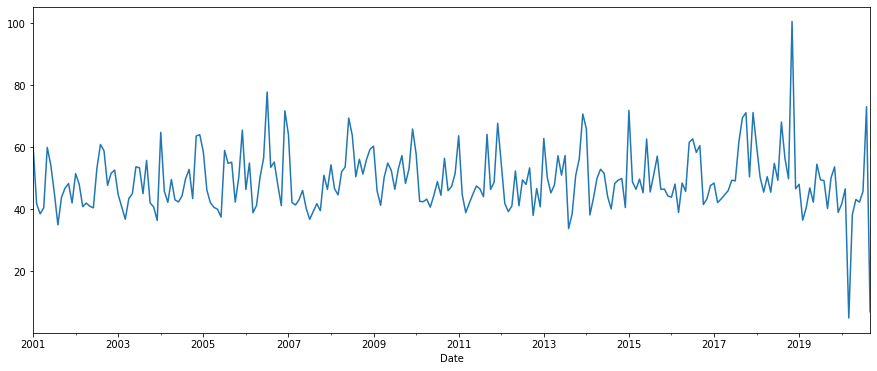

In [233]:
import matplotlib.pyplot as plt

y = Cali_PD[["Date","AQI"]]

y['Date'] = pd.to_datetime(y['Date'])
y=y.sort_values(by='Date')
y=y.reset_index(drop=True)
y.set_index('Date',inplace=True)
y = y['AQI'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

y.plot(figsize=(15, 6))
plt.show()

In [234]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [235]:
import warnings
import statsmodels.api as sm


warnings.filterwarnings("ignore") # specify to ignore warning messages
smallest=None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            if smallest is None or results.aic < smallest:
                smallest=results.aic
                valor1=param
                valor2=param_seasonal
                print(smallest,valor1,valor2)
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

2520.324655802635 (0, 0, 0) (0, 0, 0, 12)
2187.5532327450405 (0, 0, 0) (0, 0, 1, 12)
1758.4014800070186 (0, 0, 0) (0, 1, 0, 12)
1574.7156400970293 (0, 0, 0) (0, 1, 1, 12)
1566.8236309525614 (0, 0, 1) (0, 1, 1, 12)
1563.184692645701 (0, 1, 1) (0, 1, 1, 12)


In [236]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])
 


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8851      0.036    -24.327      0.000      -0.956      -0.814
ma.S.L12      -1.1417      0.091    -12.540      0.000      -1.320      -0.963
sigma2        70.8531     11.310      6.265      0.000      48.686      93.020


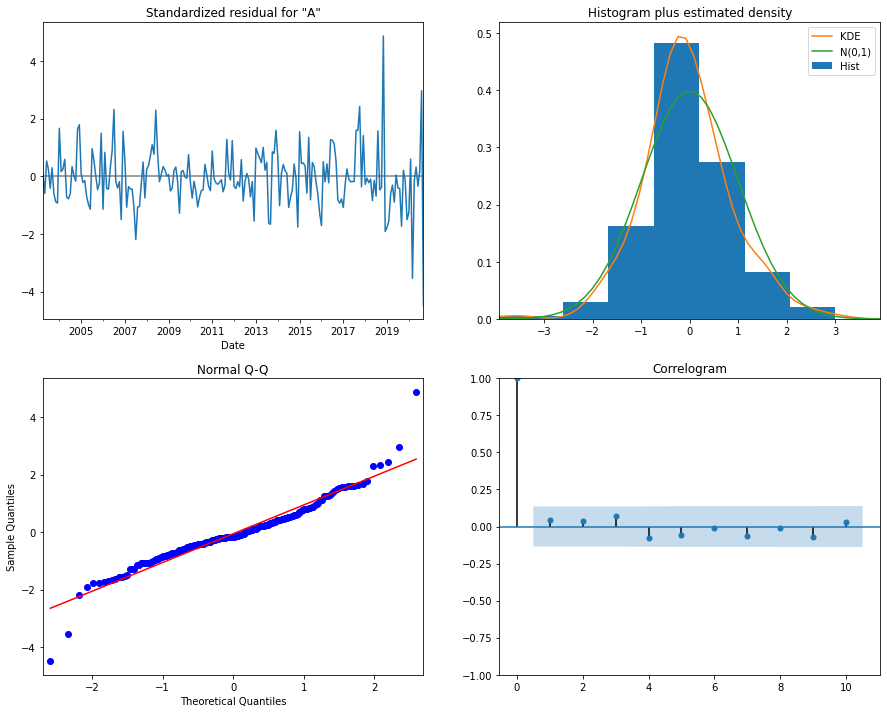

In [237]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()
 

In [243]:
pred3 = results.get_prediction(start=pd.to_datetime('2020-01-01'),end= pd.to_datetime('2022-10-01'), dayfirst=True, dynamic=False)
pred = pred3.predicted_mean
modified = pred.reset_index(drop=False)
modified = pd.DataFrame(modified)
modified = modified.rename(columns={"index":"Date"})
print(modified)

#print(y[108:])

         Date  predicted_mean
0  2020-01-01       53.914254
1  2020-02-01       40.821633
2  2020-03-01       39.074601
3  2020-04-01       39.581337
4  2020-05-01       40.047657
5  2020-06-01       45.596222
6  2020-07-01       43.963637
7  2020-08-01       44.449111
8  2020-09-01       50.150225
9  2020-10-01       40.411212
10 2020-11-01       46.814172
11 2020-12-01       43.661035
12 2021-01-01       45.825289
13 2021-02-01       36.214447
14 2021-03-01       28.889057
15 2021-04-01       36.933384
16 2021-05-01       38.087497
17 2021-06-01       42.518811
18 2021-07-01       41.854251
19 2021-08-01       45.523994
20 2021-09-01       39.352434
21 2021-10-01       39.363742
22 2021-11-01       45.766703
23 2021-12-01       42.613566
24 2022-01-01       44.777819
25 2022-02-01       35.166977
26 2022-03-01       27.841588
27 2022-04-01       35.885914
28 2022-05-01       37.040028
29 2022-06-01       41.471341
30 2022-07-01       40.806782
31 2022-08-01       44.476524
32 2022-09

In [239]:
actual_y = y.reset_index(drop=False)

actual_y = pd.DataFrame(actual_y)

actual_y = actual_y[108:]

actual_y = actual_y.rename(columns={"AQI":"actual_value"})
print(actual_y)


          Date  actual_value
108 2010-01-01     57.935484
109 2010-02-01     42.571429
110 2010-03-01     42.451613
111 2010-04-01     43.266667
112 2010-05-01     40.709677
..         ...           ...
232 2020-05-01     43.161290
233 2020-06-01     42.300000
234 2020-07-01     45.741935
235 2020-08-01     73.032258
236 2020-09-01      7.000000

[129 rows x 2 columns]


In [240]:
final_compare = pd.merge(modified,actual_y,on=["Date", "Date"])
print(final_compare)

         Date  predicted_mean  actual_value
0  2019-01-01       65.109983     48.064516
1  2019-02-01       51.442099     36.500000
2  2019-03-01       46.386593     40.516129
3  2019-04-01       49.855094     46.900000
4  2019-05-01       50.885374     42.290323
5  2019-06-01       54.072115     54.533333
6  2019-07-01       53.413380     49.516129
7  2019-08-01       53.324105     49.258065
8  2019-09-01       56.920378     40.233333
9  2019-10-01       48.104376     50.161290
10 2019-11-01       55.160948     53.666667
11 2019-12-01       53.493985     39.000000
12 2020-01-01       53.914254     41.709677
13 2020-02-01       40.821633     46.586207
14 2020-03-01       39.074601      5.000000
15 2020-04-01       39.581337     38.266667
16 2020-05-01       40.047657     43.161290
17 2020-06-01       45.596222     42.300000
18 2020-07-01       43.963637     45.741935
19 2020-08-01       44.449111     73.032258
20 2020-09-01       50.150225      7.000000


In [241]:
import math
y_forecasted = final_compare["predicted_mean"]
y_truth = final_compare["actual_value"]
# Compute the mean square error
rmse = math.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('The root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The root Mean Squared Error of our forecasts is 15.74


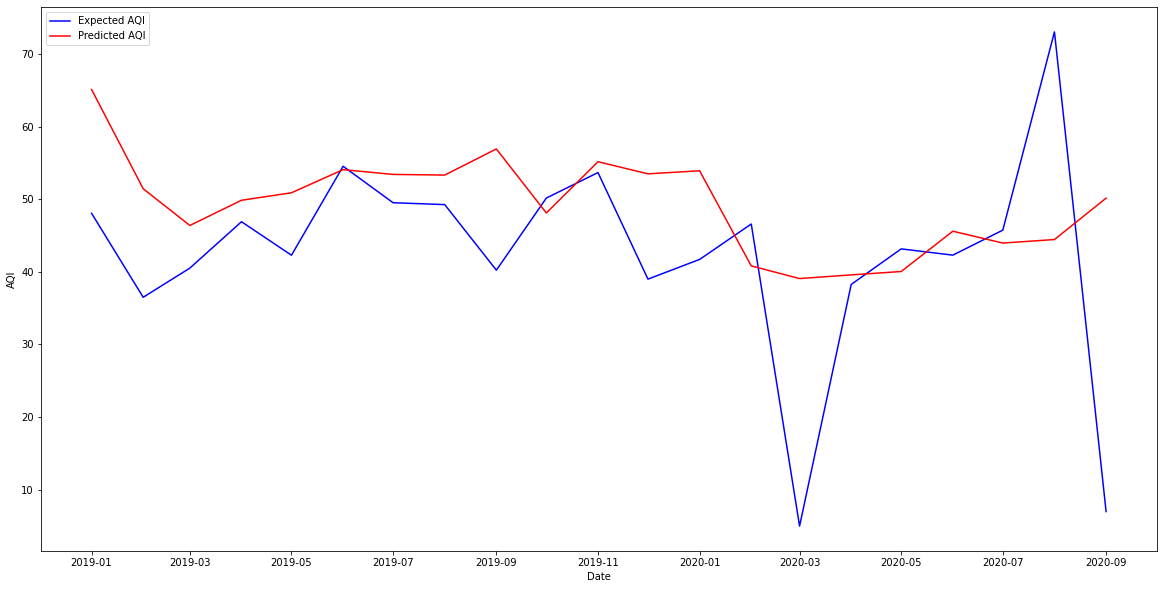

In [242]:
import matplotlib

import matplotlib.pyplot as plt

datefmt =matplotlib.dates.DateFormatter("%Y-%m-%d")
fmt = lambda x,y : "{}, {:.5g}".format(datefmt(x), y)
plt.rcParams['figure.figsize'] = (20, 10)
plt.gca().format_coord = fmt
plt.xlabel('Date')
plt.ylabel('AQI')
plt.plot(final_compare["Date"],final_compare["actual_value"].to_list(),'b',label='Expected AQI')
plt.plot(final_compare["Date"],final_compare["predicted_mean"].to_list(),'r',label='Predicted AQI')
plt.legend(loc='best')
plt.show()

In [ ]:
#forecast

pred3 = results.get_prediction(start=pd.to_datetime('2020-01-01'),end= pd.to_datetime('2022-10-01'), dayfirst=True, dynamic=False)
pred = pred3.predicted_mean

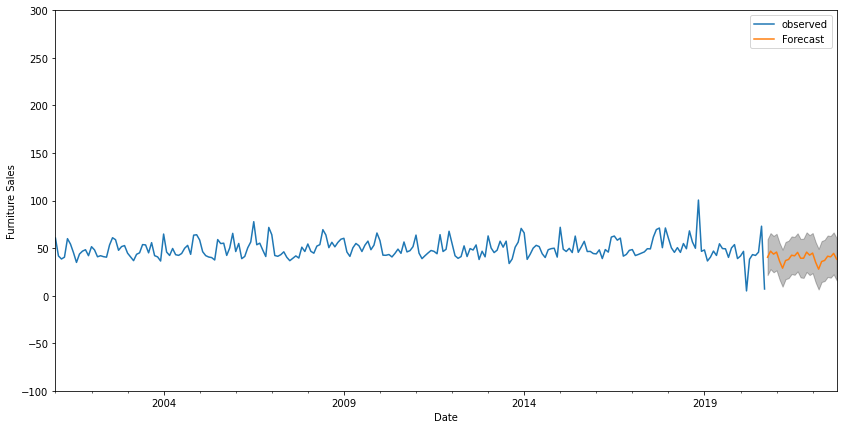

In [249]:
pred_uc = results.get_forecast(steps=24)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.ylim(-100,300)
plt.legend()
plt.show()